In [1]:
from segysak.segy import segy_loader,segy_header_scrape
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 as cv
import segyio
import os

In [18]:
def get_df_from_dat(path):
    fault_list = [fault for fault in os.listdir(path) if fault.endswith('.dat')]

    df = pd.DataFrame()

    for fault in fault_list:
        df_to_concat = pd.read_csv(f'{path}\{fault}', delim_whitespace=True, header=None)
        df_to_concat.columns = ['Name', 'Inline', 'Xline', 'Time', 'idk', 'n']

        i_or_x = 'iline' if fault.split('_')[1] == 'Inline' else 'xline'

        df_to_concat['Line'] = [i_or_x for _ in range(len(df_to_concat))]

        df = pd.concat([df, df_to_concat])

    df['Time'] /= 4
    df['Time'] = round(df['Time'])

    id = []
    count = -1
    for i in range(len(df)):
        if df['n'].iloc[i] == 0:
            count += 1
        id += [count]
    df['ID'] = id

    df.drop(['Name', 'idk', 'n'], axis=1, inplace=True)

    df = df[df.columns[::-1]]

    df.set_index('ID', inplace=True)

    return df

def norm_data(X, x_min, x_max):
    return (X - x_min) / (x_max - x_min)

def get_mask_from_dat(file_path):
    df = pd.read_csv(file_path, delim_whitespace=True)

In [3]:
faults_path = r'C:\Users\jpgom\Documents\Jão\git\facies_classification\Faults.dat'
cube_path = r'C:\Users\jpgom\Documents\Jão\UFBA\IC\Code\Seismic_data_w_null.sgy'

df = pd.read_csv(faults_path, delim_whitespace=True)

df

,ID,Line,Time,Xline,Inline
0,0,Inline,408.0,581,310
1,0,Inline,421.0,584,310
2,0,Inline,439.0,588,310
3,0,Inline,456.0,591,310
4,1,Inline,406.0,630,310
...,...,...,...,...,...
250,62,Xline,311.0,940,656
251,62,Xline,342.0,940,660
252,63,Xline,284.0,940,379
253,63,Xline,293.0,940,375


In [4]:
#cube = segy_loader(cube_path)
cube = segyio.open(cube_path)

Initial Values:
   Inline: 100 | Crossline: 300 | Time: 4.0


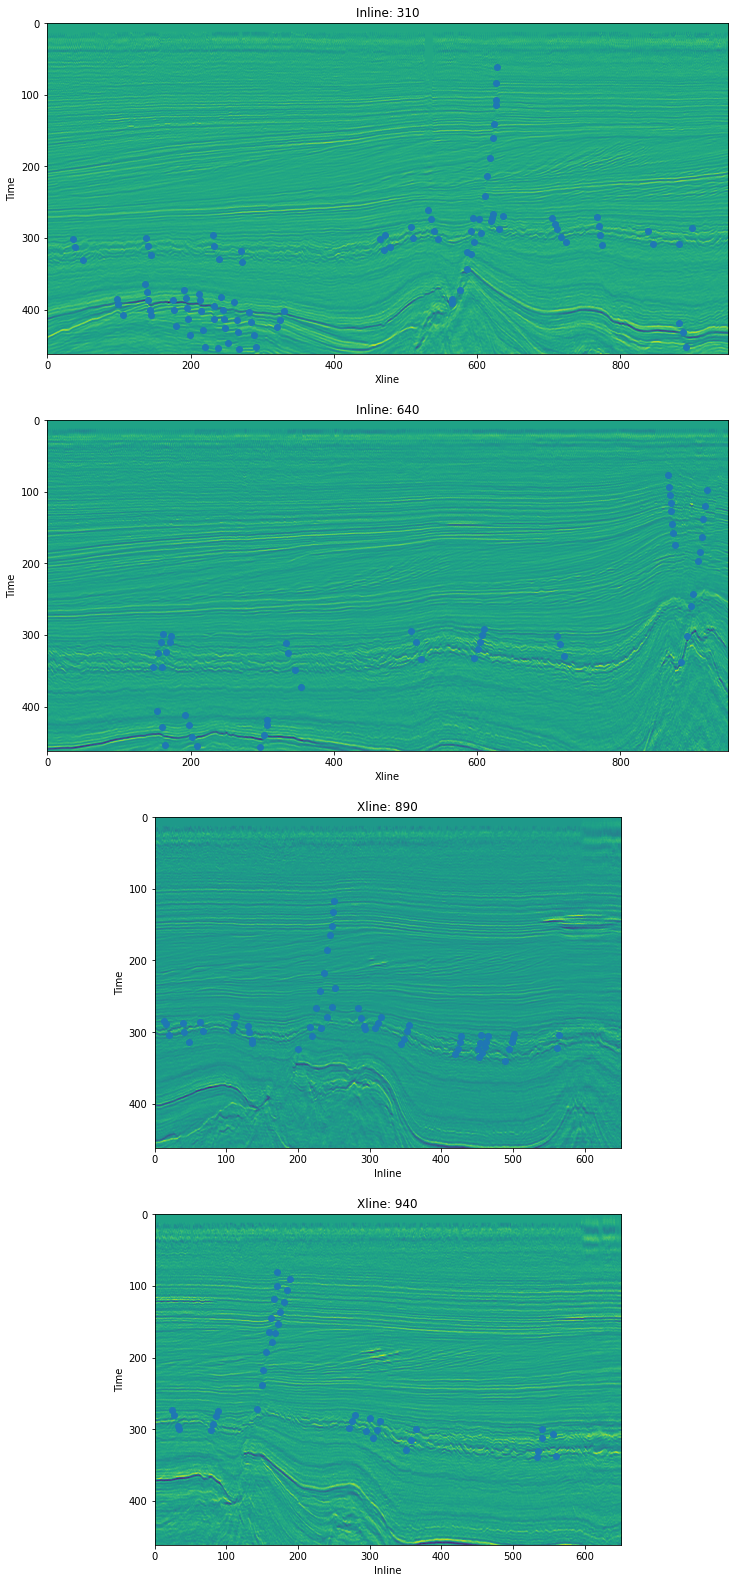

In [58]:
# iline_list = cube.iline.data
# xline_list = cube.xline.data
# twt_list = cube.twt.data
# iline0 = iline_list[0]
# xline0 = xline_list[0]
# twt0 = twt_list[0]

# print(f'Initial Values:\n   Inline: {iline0} | Crossline: {xline0} | Time: {twt0}')

# rows = len(df['Inline'][df['Line'] == 'Inline'].unique()) + len(df['Xline'][df['Line'] == 'Xline'].unique())
# cols = 1

# fig, ax = plt.subplots(rows, cols, figsize=(15 * cols, 7 * rows))
# count = 0
# for line_str in df['Line'].unique():
#     for line_number in df[line_str][df['Line'] == line_str].unique():
#         img = np.array(cube.sel(iline=line_number).data.T) if line_str == 'Inline' else np.array(cube.sel(xline=line_number).data.T)
#         mask = np.zeros_like(img) * np.nan

#         X = df['Xline'][df[line_str] == line_number][df['Line'] == line_str] - xline0 if line_str == 'Inline' else df['Inline'][df[line_str] == line_number][df['Line'] == line_str] - iline0
#         Y = df['Time'][df[line_str] == line_number][df['Line'] == line_str] - twt0

#         ax[count].imshow(img)
#         ax[count].scatter(X, Y)
#         ax[count].set_title(f'{line_str}: {line_number}')
#         if line_str == 'Inline':
#             for i in range(len())
#             cv.line(mask, (0, 0), (3, 3), (100, 0, 0))
#             ax[count].imshow(mask)
#             ax[count].set_xlabel('Xline')
#         else:
#             ax[count].set_xlabel('Inline')
#         ax[count].set_ylabel('Time')
#         count += 1

Initial Values:
   Inline: 100 | Crossline: 300


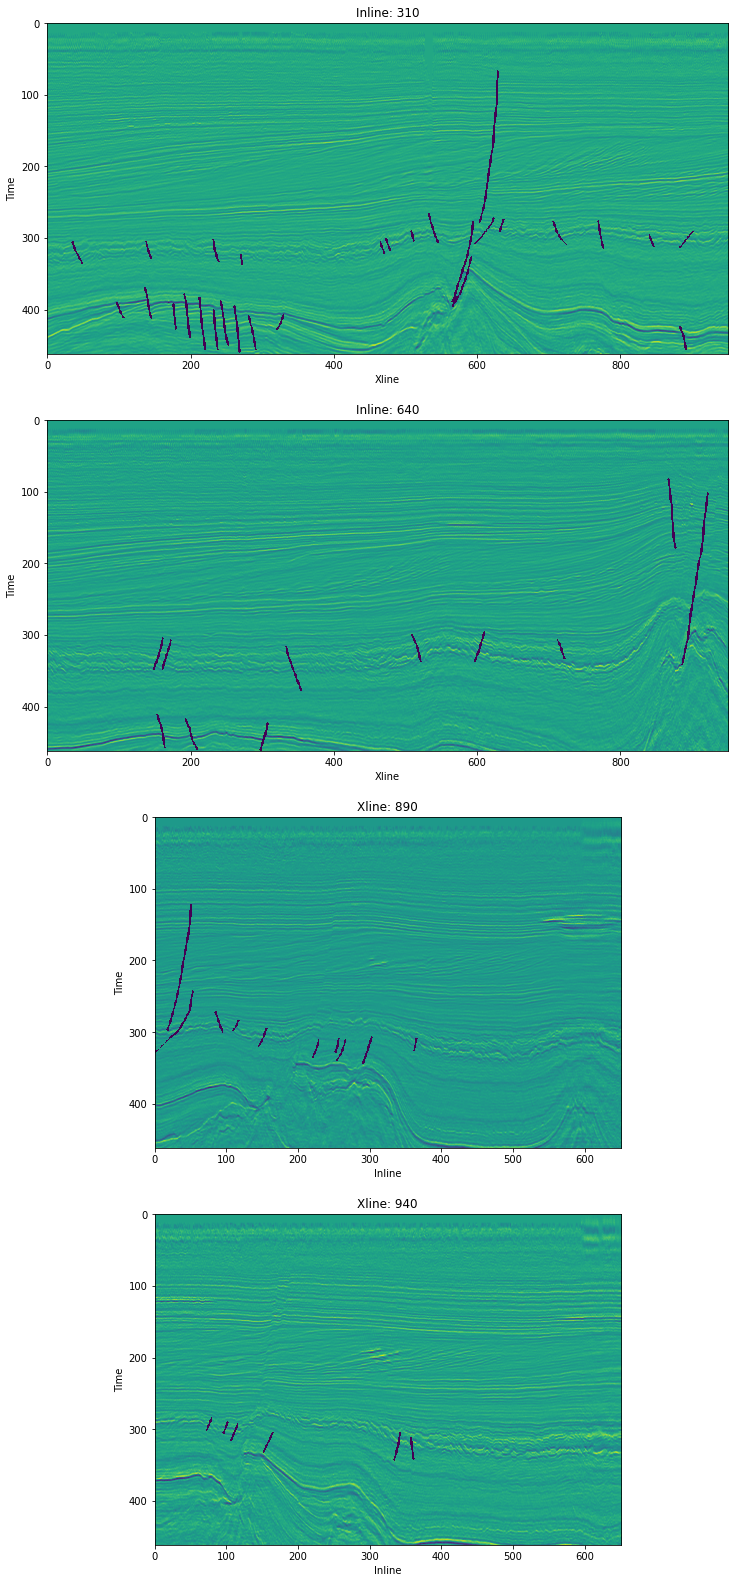

In [17]:
iline_list = cube.ilines
xline_list = cube.xlines
iline0 = iline_list[0]
xline0 = xline_list[0]

print(f'Initial Values:\n   Inline: {iline0} | Crossline: {xline0}')

rows = len(df['Inline'][df['Line'] == 'Inline'].unique()) + len(df['Xline'][df['Line'] == 'Xline'].unique())
cols = 1

fig, ax = plt.subplots(rows, cols, figsize=(15 * cols, 7 * rows))
count = 0
for line_str in df['Line'].unique():
    for line_number in df[line_str][df['Line'] == line_str].unique():
        img = cube.iline[line_number].T if line_str == 'Inline' else cube.xline[line_number].T
        mask = np.zeros(img.shape) * np.nan

        X = df['Xline'][df[line_str] == line_number][df['Line'] == line_str] - xline0 if line_str == 'Inline' else df['Inline'][df[line_str] == line_number][df['Line'] == line_str] - iline0
        Y = df['Time'][df[line_str] == line_number][df['Line'] == line_str]

        ax[count].imshow(img)
        #ax[count].scatter(X, Y)
        ax[count].set_title(f'{line_str}: {line_number}')
        if line_str == 'Inline':
            for id in df['ID'][df['Line'] == line_str][df['Inline'] == line_number].unique():
                [cv.line(mask, (int(df['Xline'][df['ID'] == id].iloc[i-1] - xline0), int(df['Time'][df['ID'] == id].iloc[i-1])), (int(df['Xline'][df['ID'] == id].iloc[i] - xline0), int(df['Time'][df['ID'] == id].iloc[i])), (1,0,0), 3) for i in range(1, len(df['ID'][df['ID'] == id]))]
            ax[count].set_xlabel('Xline')
        else:
            for id in df['ID'][df['Line'] == line_str][df['Xline'] == line_number].unique():
                [cv.line(mask, (int(df['Inline'][df['ID'] == id].iloc[i-1] - xline0), int(df['Time'][df['ID'] == id].iloc[i-1])), (int(df['Inline'][df['ID'] == id].iloc[i] - xline0), int(df['Time'][df['ID'] == id].iloc[i])), (1,0,0), 3) for i in range(1, len(df['ID'][df['ID'] == id]))]
            ax[count].set_xlabel('Inline')
        ax[count].imshow(mask)
        ax[count].set_ylabel('Time')
        count += 1

In [28]:
iline_list = cube.ilines
xline_list = cube.xlines
iline0 = iline_list[0]
xline0 = xline_list[0]

for line_str in df['Line'].unique():
    for line_number in df[line_str][df['Line'] == line_str].unique():
        img = cube.iline[line_number].T if line_str == 'Inline' else cube.xline[line_number].T
        mask = np.zeros(img.shape) * np.nan

        if line_str == 'Inline':
            for id in df['ID'][df['Line'] == line_str][df['Inline'] == line_number].unique():
                [cv.line(mask, (int(df['Xline'][df['ID'] == id].iloc[i-1] - xline0), int(df['Time'][df['ID'] == id].iloc[i-1])), (int(df['Xline'][df['ID'] == id].iloc[i] - xline0), int(df['Time'][df['ID'] == id].iloc[i])), (1,0,0), 3) for i in range(1, len(df['ID'][df['ID'] == id]))]
        else:
            for id in df['ID'][df['Line'] == line_str][df['Xline'] == line_number].unique():
                [cv.line(mask, (int(df['Inline'][df['ID'] == id].iloc[i-1] - xline0), int(df['Time'][df['ID'] == id].iloc[i-1])), (int(df['Inline'][df['ID'] == id].iloc[i] - xline0), int(df['Time'][df['ID'] == id].iloc[i])), (1,0,0), 3) for i in range(1, len(df['ID'][df['ID'] == id]))]

        

In [57]:
width = 15
height = 15

dataset = pd.DataFrame()
for i in range(img.shape[0] - (height - 1)):
        
    for j in range(img.shape[1] - (width - 1)):
            
        window_amplitude = img[i : i + height, j : j + width]
        window_amplitude = norm_data(window_amplitude, np.min(window_amplitude), np.max(window_amplitude))
        
        window_mask = mask[i : i + height, j : j + width]

        X = window_amplitude.reshape(1,-1)
        y = window_mask.reshape(1,-1)
        
        pd.concat([dataset])

        dataset = pd.concat([dataset, pd.Series(X[0], name=f'X{i}{j}')], axis=1)
        dataset = pd.concat([dataset, pd.Series(y[0], name=f'y{i}{j}')], axis=1)


KeyboardInterrupt: 

In [58]:
dataset

,X00,y00,X01,y01,X02,y02,X03,y03,X04,y04,...,X13617,y13617,X13618,y13618,X13619,y13619,X13620,y13620,X13621,y13621
0,0.625696,NaN,0.625696,NaN,0.625696,NaN,0.625696,NaN,0.625696,NaN,...,1.000000,NaN,0.754569,NaN,0.742877,NaN,0.730276,NaN,0.760699,NaN
1,0.625696,NaN,0.625696,NaN,0.625696,NaN,0.625696,NaN,0.625696,NaN,...,0.659948,NaN,0.742877,NaN,0.730276,NaN,0.760699,NaN,0.734022,NaN
2,0.625696,NaN,0.625696,NaN,0.625696,NaN,0.625696,NaN,0.625696,NaN,...,0.649722,NaN,0.730276,NaN,0.760699,NaN,0.734022,NaN,0.727778,NaN
3,0.625696,NaN,0.625696,NaN,0.625696,NaN,0.625696,NaN,0.625696,NaN,...,0.638701,NaN,0.760699,NaN,0.734022,NaN,0.727778,NaN,0.763310,NaN
4,0.625696,NaN,0.625696,NaN,0.625696,NaN,0.625696,NaN,0.625696,NaN,...,0.665310,NaN,0.734022,NaN,0.727778,NaN,0.763310,NaN,0.878647,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,0.625696,NaN,0.349506,NaN,0.173944,NaN,0.161545,NaN,0.349146,NaN,...,0.412133,NaN,0.490635,NaN,0.376320,NaN,0.312067,NaN,0.477239,NaN
221,0.349506,NaN,0.173944,NaN,0.161545,NaN,0.349146,NaN,0.461096,NaN,...,0.429110,NaN,0.376320,NaN,0.312067,NaN,0.477239,NaN,0.386877,NaN
222,0.173944,NaN,0.161545,NaN,0.349146,NaN,0.461096,NaN,0.414915,NaN,...,0.329130,NaN,0.312067,NaN,0.477239,NaN,0.386877,NaN,0.610739,NaN
223,0.161545,NaN,0.349146,NaN,0.461096,NaN,0.414915,NaN,0.373765,NaN,...,0.272935,NaN,0.477239,NaN,0.386877,NaN,0.610739,NaN,0.638438,NaN


0      0.625696
1      0.625696
2      0.625696
3      0.625696
4      0.625696
         ...   
220    0.625696
221    0.349506
222    0.173944
223    0.161545
224    0.349146
Name: X00, Length: 225, dtype: float64